In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.validation import _check_large_sparse
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [3]:
X_df = pd.read_csv('../new_data/NA/na_dataset.csv', index_col=None)
Y_df = pd.read_csv('../new_data/NA/na_labels.csv', usecols=['filename', 'emotions'], index_col='filename')
Y_df["emotions"] = Y_df["emotions"].apply(eval)
unique_items = to_1D(Y_df["emotions"]).unique()
labels_expanded = boolean_df(Y_df['emotions'], unique_items)
labels_expanded

,none,furious,anger,annoyed,contempt,disgust,hatred
filename,,,,,,,
na/vid_1.mp4,1,0,0,0,0,0,0
na/vid_100.mp4,0,1,0,0,0,0,0
na/vid_101.mp4,0,1,0,0,0,0,0
na/vid_102.mp4,0,0,1,0,0,0,0
na/vid_104.mp4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
na/vid_90.mp4,0,0,1,0,0,0,0
na/vid_92.mp4,0,0,1,0,0,0,0
na/vid_93.mp4,0,0,1,0,0,0,0


In [4]:
X_df['none']  = np.NaN
X_df['furious']  = np.NaN
X_df['anger']  = np.NaN
X_df['annoyed']  = np.NaN
X_df['contempt']  = np.NaN
X_df['disgust']  = np.NaN
X_df['hatred']  = np.NaN


In [ ]:
X_df.head()

In [4]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
    X_df.at[index,'none'] = labels_expanded.at[filename,'none']
    X_df.at[index,'furious'] = labels_expanded.at[filename,'furious']
    X_df.at[index,'anger'] = labels_expanded.at[filename,'anger']
    X_df.at[index,'annoyed'] = labels_expanded.at[filename,'annoyed']
    X_df.at[index,'contempt'] = labels_expanded.at[filename,'contempt']
    X_df.at[index,'disgust'] = labels_expanded.at[filename,'disgust']
    X_df.at[index,'hatred'] = labels_expanded.at[filename,'hatred']

### Min-Max Scaling

In [20]:
## Ablation cols
# ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']
ablation_cols = ['pose_Rx','pose_Ry','pose_Rz','gaze_angle_x','gaze_angle_y']

In [21]:
X_df = X_df.drop(columns=ablation_cols)
X_df

,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,AU25_r,AU26_r,AU45_r,none,furious,anger,annoyed,contempt,disgust,hatred
0,na/vid_1.mp4,north american,1,0,0.000,0.98,1,0.386667,0.372,0.000000,...,0.132,0.040,0.394,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,na/vid_1.mp4,north american,2,0,0.017,0.98,1,0.400000,0.396,0.000000,...,0.138,0.066,0.372,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,na/vid_1.mp4,north american,3,0,0.033,0.98,1,0.418667,0.396,0.000000,...,0.138,0.062,0.376,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,na/vid_1.mp4,north american,4,0,0.050,0.98,1,0.416000,0.398,0.000000,...,0.134,0.048,0.378,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,na/vid_1.mp4,north american,5,0,0.067,0.98,1,0.373333,0.388,0.000000,...,0.130,0.056,0.384,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6871,na/vid_97.mp4,north american,92,0,3.792,0.88,1,0.176000,0.000,0.778098,...,0.244,0.234,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6872,na/vid_97.mp4,north american,93,0,3.833,0.88,1,0.000000,0.000,0.789625,...,0.152,0.268,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6873,na/vid_97.mp4,north american,94,0,3.875,0.88,1,0.021333,0.000,0.821326,...,0.114,0.088,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6874,na/vid_97.mp4,north american,95,0,3.917,0.88,1,0.000000,0.000,0.853026,...,0.182,0.000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success', 'none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred'])
)
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [ ]:
X_df.tail()

## Splitting into train and test

In [12]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
label_cols = ['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']

print(X_df.head())
videos = X_df['filename'].unique()
# test_videos = pd.Series(videos).sample(frac=0.35)
# test_videos = ['persian/vid_52.mp4', 'persian/vid_40.mp4', 'persian/vid_66.mp4', 'persian/vid_18.mp4', 'persian/vid_96.mp4', 'persian/vid_65.mp4', 'persian/vid_51.mp4', 'persian/vid_85.mp4', 'persian/vid_87.mp4', 'persian/vid_70.mp4', 'persian/vid_76.mp4', 'persian/vid_27.mp4', 'persian/vid_88.mp4', 'persian/vid_21.mp4', 'persian/vid_4.mp4', 'persian/vid_61.mp4', 'persian/vid_12.mp4', 'persian/vid_46.mp4', 'persian/vid_81.mp4', 'persian/vid_93.mp4', 'persian/vid_56.mp4', 'persian/vid_55.mp4', 'persian/vid_68.mp4', 'persian/vid_38.mp4', 'persian/vid_62.mp4', 'persian/vid_14.mp4', 'persian/vid_8.mp4', 'persian/vid_83.mp4', 'persian/vid_45.mp4', 'persian/vid_91.mp4', 'persian/vid_22.mp4', 'persian/vid_36.mp4', 'persian/vid_7.mp4']
test_videos = ['na/vid_6.mp4', 'na/vid_19.mp4', 'na/vid_43.mp4', 'na/vid_25.mp4', 'na/vid_23.mp4', 'na/vid_10_1.mp4', 'na/vid_72.mp4', 'na/vid_34.mp4', 'na/vid_90.mp4', 'na/vid_92.mp4', 'na/vid_39.mp4', 'na/vid_30.mp4', 'na/vid_3.mp4', 'na/vid_33.mp4', 'na/vid_4.mp4', 'na/vid_31.mp4', 'na/vid_53.mp4', 'na/vid_52.mp4', 'na/vid_55.mp4', 'na/vid_59.mp4', 'na/vid_22.mp4', 'na/vid_11.mp4', 'na/vid_79.mp4', 'na/vid_54.mp4', 'na/vid_87.mp4', 'na/vid_63.mp4', 'na/vid_12.mp4', 'na/vid_10_2.mp4', 'na/vid_97.mp4', 'na/vid_70.mp4', 'na/vid_42.mp4', 'na/vid_49.mp4', 'na/vid_77.mp4']
train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
y_test = test_df[label_cols].values
X_test = test_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values

       filename         culture  frame  face_id  timestamp  confidence  \
0  na/vid_1.mp4  north american      1        0      0.000        0.98   
1  na/vid_1.mp4  north american      2        0      0.017        0.98   
2  na/vid_1.mp4  north american      3        0      0.033        0.98   
3  na/vid_1.mp4  north american      4        0      0.050        0.98   
4  na/vid_1.mp4  north american      5        0      0.067        0.98   

   success    AU01_r  AU02_r  AU04_r  ...   pose_Rz  gaze_angle_x  \
0        1  0.386667   0.372     0.0  ...  0.241562      0.527431   
1        1  0.400000   0.396     0.0  ...  0.241080      0.524172   
2        1  0.418667   0.396     0.0  ...  0.240598      0.523628   
3        1  0.416000   0.398     0.0  ...  0.240598      0.523628   
4        1  0.373333   0.388     0.0  ...  0.235776      0.519826   

   gaze_angle_y  none  furious  anger  annoyed  contempt  disgust  hatred  
0      0.655223   1.0      0.0    0.0      0.0       0.0      0.

In [ ]:
y_test[800:805,:]


In [ ]:
metadata_test.iloc[800:805]

## Cross-validation

### Classifier Chain

In [8]:
print(test_df['filename'].unique())
print(train_videos)

['na/vid_10_1.mp4' 'na/vid_10_2.mp4' 'na/vid_11.mp4' 'na/vid_12.mp4'
 'na/vid_19.mp4' 'na/vid_22.mp4' 'na/vid_23.mp4' 'na/vid_25.mp4'
 'na/vid_3.mp4' 'na/vid_30.mp4' 'na/vid_31.mp4' 'na/vid_33.mp4'
 'na/vid_34.mp4' 'na/vid_39.mp4' 'na/vid_4.mp4' 'na/vid_42.mp4'
 'na/vid_43.mp4' 'na/vid_49.mp4' 'na/vid_52.mp4' 'na/vid_53.mp4'
 'na/vid_54.mp4' 'na/vid_55.mp4' 'na/vid_59.mp4' 'na/vid_6.mp4'
 'na/vid_63.mp4' 'na/vid_70.mp4' 'na/vid_72.mp4' 'na/vid_77.mp4'
 'na/vid_79.mp4' 'na/vid_87.mp4' 'na/vid_90.mp4' 'na/vid_92.mp4'
 'na/vid_97.mp4']
['na/vid_2.mp4' 'na/vid_93.mp4' 'na/vid_27.mp4' 'na/vid_83.mp4'
 'na/vid_50.mp4' 'na/vid_69.mp4' 'na/vid_60.mp4' 'na/vid_15.mp4'
 'na/vid_21.mp4' 'na/vid_26.mp4' 'na/vid_82.mp4' 'na/vid_68.mp4'
 'na/vid_37.mp4' 'na/vid_18.mp4' 'na/vid_62.mp4' 'na/vid_5.mp4'
 'na/vid_67.mp4' 'na/vid_47.mp4' 'na/vid_66.mp4' 'na/vid_17.mp4'
 'na/vid_32.mp4' 'na/vid_44.mp4' 'na/vid_16.mp4' 'na/vid_76.mp4'
 'na/vid_13.mp4' 'na/vid_101.mp4' 'na/vid_24.mp4' 'na/vid_1.mp4'
 'na/vid

In [13]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []

col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    print(train_videos[train])
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_lr = LogisticRegression()
    base_rf = RandomForestClassifier()

    ovr = OneVsRestClassifier(base_knn)
    ovr.fit(X_train, y_train)
    valid_pred_ovr = ovr.predict(X_valid)
    ovr_jaccard_score = jaccard_score(y_valid, valid_pred_ovr, average='samples')
    ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_ovr)
    print("One-vs-Rest validation Jaccard score:" , ovr_jaccard_score)
    print("One-vs-Rest validation Hamming loss: " , ovr_ham_loss)

   
    Y_pred_ovr = ovr.predict(X_test)
    a = jaccard_score(y_test, Y_pred_ovr, average='samples')
    b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # print(Y_pred_ovr[800:805,:])
    # print(y_test[800:805,:])

    print("One-vs-Rest test Jaccard score: ", a)
    print("One-vs-Rest test Hamming loss: " , b)
    # set order from higher arousal emotions to lower arousal.
    # order=[1, 6, 2, 5, 4, 3, 0]
    chains = [ClassifierChain(base_knn, order='random', random_state=i)
            for i in range(1)]
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        
        
    # predict on validation data
    valid_pred_chains = np.array([chain.predict(X_valid) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_valid, valid_pred_chain >= .5,
                                    average='samples')
                    for valid_pred_chain in valid_pred_chains]
    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_valid, valid_pred_chain >= .5)
                for valid_pred_chain in valid_pred_chains]
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = np.array([chain.predict(X_test) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5,
                                    average='samples')
                    for Y_pred_chain in Y_pred_chains]

    chain01_scores = [metrics.zero_one_loss(y_test, Y_pred_chain) for Y_pred_chain in Y_pred_chains]

    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_test, Y_pred_chain) 
                for Y_pred_chain in Y_pred_chains]
    frames_mean_hm_test.append(np.mean(chain_hamming_loss))
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains[-1], columns=label_cols)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x :              x.astype(int).sum())
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0
        # print("          &&&&&&&&&&&&&&&&            ")
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 48, test: 13
['na/vid_81.mp4' 'na/vid_44.mp4' 'na/vid_26.mp4' 'na/vid_17.mp4'
 'na/vid_56.mp4' 'na/vid_1.mp4' 'na/vid_86.mp4' 'na/vid_60.mp4'
 'na/vid_74.mp4' 'na/vid_69.mp4' 'na/vid_68.mp4' 'na/vid_20.mp4'
 'na/vid_78.mp4' 'na/vid_35.mp4' 'na/vid_101.mp4' 'na/vid_45.mp4'
 'na/vid_13.mp4' 'na/vid_66.mp4' 'na/vid_73.mp4' 'na/vid_65.mp4'
 'na/vid_95.mp4' 'na/vid_16.mp4' 'na/vid_5.mp4' 'na/vid_32.mp4'
 'na/vid_29.mp4' 'na/vid_50.mp4' 'na/vid_82.mp4' 'na/vid_67.mp4'
 'na/vid_38.mp4' 'na/vid_83.mp4' 'na/vid_75.mp4' 'na/vid_24.mp4'
 'na/vid_84.mp4' 'na/vid_27.mp4' 'na/vid_10_3.mp4' 'na/vid_104.mp4'
 'na/vid_89.mp4' 'na/vid_14.mp4' 'na/vid_21.mp4' 'na/vid_46.mp4'
 'na/vid_62.mp4' 'na/vid_48.mp4' 'na/vid_15.mp4' 'na/vid_80.mp4'
 'na/vid_58.mp4' 'na/vid_8.mp4' 'na/vid_36.mp4' 'na/vid_2.mp4']
Training+validation data size:  3424
Training data size:  3424
Validation data size:  1200
One-vs-Rest validation Jaccard score: 1.0
One-vs-Rest validation Hamming loss:  0.0
One-vs-Rest 

In [15]:
print(metrics.classification_report(y_test, Y_pred_chains[-1], target_names=label_cols))

              precision    recall  f1-score   support

        none       1.00      1.00      1.00       366
     furious       1.00      0.86      0.92       252
       anger       1.00      0.70      0.82       441
     annoyed       1.00      0.98      0.99       664
    contempt       1.00      0.97      0.99       426
     disgust       1.00      0.81      0.89       596
      hatred       0.00      0.00      0.00         0

   micro avg       1.00      0.89      0.94      2745
   macro avg       0.86      0.76      0.80      2745
weighted avg       1.00      0.89      0.94      2745
 samples avg       1.00      0.94      0.96      2745



In [23]:
videos_mean_jac_test

[0.8010752688172043,
 0.7591397849462365,
 0.8010752688172043,
 0.8010752688172043,
 0.8010752688172043]

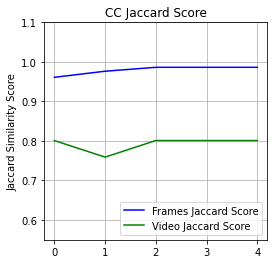

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.55, 1.1])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

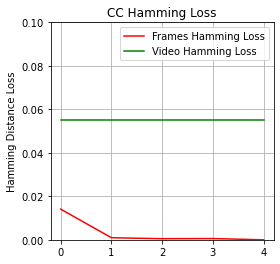

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

### ML KNN

In [27]:
from skmultilearn.adapt import MLkNN, MLTSVM
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    print('%d-th split: train: %d, validation: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success']).values
    
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    # print("^^^^^^^^", y_test_pred.toarray().shape)
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=label_cols)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)
        

1-th split: train: 48, validation: 13
Training+validation data size:  3770
Training data size:  3770
Validation data size:  854
Validation Hamming Loss:
  0.0013382402141184342
Test Hamming Loss:
  0.007548845470692718
Test Jaccard Score:
  0.9820159857904085
2-th split: train: 49, validation: 12
Training+validation data size:  3609
Training data size:  3609
Validation data size:  1015
Validation Hamming Loss:
  0.027726952850105558
Test Hamming Loss:
  0.01446333417914235
Test Jaccard Score:
  0.957445233866193
3-th split: train: 49, validation: 12
Training+validation data size:  3599
Training data size:  3599
Validation data size:  1025
Validation Hamming Loss:
  0.0
Test Hamming Loss:
  0.007358538442019792
Test Jaccard Score:
  0.9826820603907638
4-th split: train: 49, validation: 12
Training+validation data size:  3830
Training data size:  3830
Validation data size:  794
Validation Hamming Loss:
  0.0008996041741633681
Test Hamming Loss:
  0.012814006597310327
Test Jaccard Score:


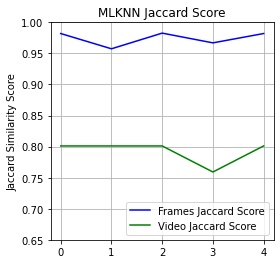

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.65, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

In [30]:
videos_mean_jac_test


[0.8010752688172043,
 0.8010752688172043,
 0.8010752688172043,
 0.7591397849462365,
 0.8010752688172043]

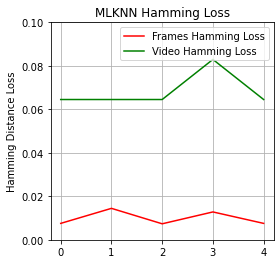

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [32]:
videos_mean_hm_test

[0.06451612903225806,
 0.06451612903225806,
 0.06451612903225806,
 0.08294930875576037,
 0.06451612903225806]

In [ ]:
train_df.head()

Multilabel confusion matrix puts TN at (0,0) and TP at (1,1) position thanks @Kenneth Witham for pointing out.


In [ ]:
multilabel_confusion_matrix(y_test, y_test_pred, labels=range(0,7))


`support`: The number of occurrences of each label in y_true.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=['none', 'furious', 'anger', 'annoyed', 'contempt', 'disgust', 'hatred']))

In [ ]:
print(type(y_test[0]))
print(type(y_test_pred[0].toarray()))
for i in range(len(y_test)):
    if metrics.hamming_loss(y_test[i].flatten(), Y_pred_chains[4][i].flatten()) > 0:
        print("Ground Truth: ", y_test[i], ", Prediction: ", Y_pred_chains[0][i])
        print("Video data: ", metadata_test.iloc[i])

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)